In [1]:
import time
import os
import cv2

from lib.file.TIF import *
from lib.analysis.ROI_identification import *
from lib.file.ROI_writer import ROIFileWriter
from lib.file.ROI_reader import ROIFileReader
from lib.file.TSV import RegionExporter
from lib.analysis.align import ImageAlign
from lib.file.DAT import TracesDAT
from lib.trace import Tracer
from lib.utilities import *
from lib.analysis.laminar_dist import *

####### GRID ROIS #######
# for each recording:
## 1) divide the entire frame of recording into grid of square n_sq x n_sq ROIs
## 2) write these grid square ROIs to file
## 3) take SNRs and latencies to .dat file of each ROI from PhotoZ
## filter out no-response grid squares by SNR cutoff (or manual inspection?)
## write out output file of (ROI center x, ROI center y, SNR, latency)
## analysis: directed graph analysis of latency, 3-D plot of latency, 3-D plot of SNR

In [2]:
data_dir = "C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/"

n_sq = 10  # number of pixels of each square edge in the grid.
snr_cutoff_sq = 5.0  # SNR cutoff 

# sets of files in each slice directory -- naming convention
# input
corners_file_prefix_layer = 'corners_layer'  # defines axes of L4 boundaries
electrode_file_prefix = 'electrode'
# also needed: 01_01_01_snr.dat

# output files
rois_file_prefix = 'sq_rois' # e.g. 'sq_rois_01_to_09.dat'

image_data = {}
n_plots = 5000  # show up to how many plots
tol_exception_count = 0
slice_count = 0
meas_count = 0

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/02-28-23\selected_zda
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/02-28-23\selected_zda\analysis02_01_01
slice 2 , rec 1
Processing C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/02-28-23\selected_zda\analysis02_01_01/corners_layer.dat
edge_pts [[8, 69], [37, 71]] axis_pts [[44, 10], [77, 17]]
laminar axis unit vectors: [-0.5208646456291304, 0.8536392803366304] [-0.5952275506257376, 0.8035571933447457]
ROI centers: [[50.77, 7.08], [40.14, 0.75], [45.71, 15.32], [56.02, 24.8], [66.02, 34.8], [74.59, 44.84], [55.93, 1.29], [61.31, 16.09], [71.31, 26.09], [77.17, 36.02], [66.71, 7.6], [74.88, 17.59], [35.3, 5.81], [40.74, 23.75], [50.86, 33.34], [60.86, 43.34], [70.86, 53.34], [76.98, 63.2], [30.42, 14.28], [20.45, 4.32], [35.18, 32.38], [45.44, 42.0], [55.44, 52.0], [65.44, 62.0], [74.25, 72.11], [24.85, 22.75], [14.85, 12.75], [5.63, 3.18], [30.14, 40.71], [40.27, 50.43], [50.27, 60.4

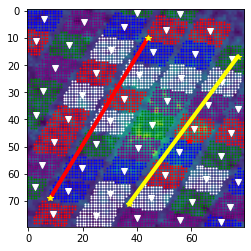

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/02-28-23\selected_zda\analysis02_01_03
slice 2 , rec 3
Processing C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/02-28-23\selected_zda\analysis02_01_03/corners_layer.dat
edge_pts [[8, 69], [37, 71]] axis_pts [[44, 10], [77, 17]]
laminar axis unit vectors: [-0.5208646456291304, 0.8536392803366304] [-0.5952275506257376, 0.8035571933447457]
ROI centers: [[50.77, 7.08], [40.14, 0.75], [45.71, 15.32], [56.02, 24.8], [66.02, 34.8], [74.59, 44.84], [55.93, 1.29], [61.31, 16.09], [71.31, 26.09], [77.17, 36.02], [66.71, 7.6], [74.88, 17.59], [35.3, 5.81], [40.74, 23.75], [50.86, 33.34], [60.86, 43.34], [70.86, 53.34], [76.98, 63.2], [30.42, 14.28], [20.45, 4.32], [35.18, 32.38], [45.44, 42.0], [55.44, 52.0], [65.44, 62.0], [74.25, 72.11], [24.85, 22.75], [14.85, 12.75], [5.63, 3.18], [30.14, 40.71], [40.27, 50.43], [50.27, 60.43], [60.27, 70.43], [70.89, 77.74], [19.92, 31.19], [9.92, 21.19], [2.95, 11.27], [24.9

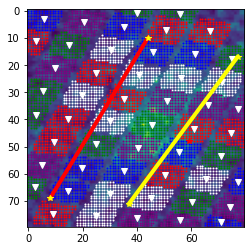

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/02-28-23\selected_zda\analysis02_02_02
slice 2 , rec 2
Processing C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/02-28-23\selected_zda\analysis02_02_02/corners_layer.dat
edge_pts [[39, 70], [8, 68]] axis_pts [[72, 15], [44, 10]]
laminar axis unit vectors: [-0.5144957554275266, 0.8574929257125442] [-0.5273628617781428, 0.8496401661981191]
ROI centers: [[70.0, 10.4], [59.6, 2.18], [64.92, 18.64], [74.27, 28.23], [74.0, 2.94], [76.72, 19.38], [54.76, 9.12], [44.17, 1.6], [59.58, 27.12], [69.84, 36.78], [76.52, 46.73], [49.3, 17.7], [39.3, 7.7], [28.62, 0.79], [54.79, 35.75], [64.97, 45.31], [73.99, 55.45], [44.45, 26.31], [34.45, 16.31], [24.45, 6.31], [49.59, 44.35], [59.85, 53.92], [69.85, 63.92], [76.47, 73.82], [39.18, 34.79], [29.18, 24.79], [19.18, 14.79], [9.18, 4.79], [44.28, 52.95], [54.43, 62.58], [64.43, 72.58], [33.98, 43.38], [23.98, 33.38], [13.98, 23.38], [4.96, 13.23], [39.17, 61.49], [49.42

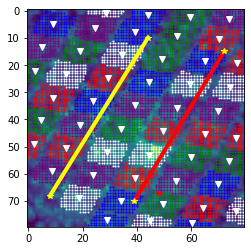

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/02-28-23\selected_zda\analysis03_01_01
slice 3 , rec 1
Processing C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/02-28-23\selected_zda\analysis03_01_01/corners_layer.dat
edge_pts [[18, 69], [48, 72]] axis_pts [[26, 9], [56, 11]]
laminar axis unit vectors: [-0.13216372009101796, 0.9912279006826347] [-0.13003403680018621, 0.9915095306014198]
ROI centers: [[31.14, 4.82], [29.84, 14.25], [40.0, 23.73], [50.0, 33.73], [60.0, 43.73], [70.0, 53.73], [76.66, 63.77], [41.7, 13.79], [51.7, 23.79], [61.7, 33.79], [71.7, 43.79], [77.76, 53.85], [43.08, 4.23], [53.01, 13.9], [63.01, 23.9], [73.01, 33.9], [19.3, 4.68], [28.01, 24.01], [38.11, 33.53], [48.11, 43.53], [58.11, 53.53], [68.11, 63.53], [76.04, 73.57], [17.85, 14.6], [7.85, 4.6], [26.77, 34.1], [36.84, 43.57], [46.84, 53.57], [56.84, 63.57], [66.84, 73.57], [16.6, 24.52], [6.6, 14.52], [0.89, 4.11], [25.45, 43.99], [35.5, 53.5], [45.5, 63.5], [55.5, 73.5], 

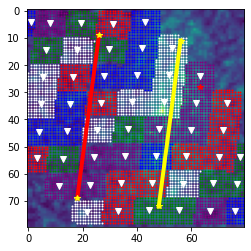

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/02-28-23\selected_zda\analysis03_02_01
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/02-28-23\selected_zda\analysis03_02_02
slice 3 , rec 2
Processing C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/02-28-23\selected_zda\analysis03_02_02/corners_layer.dat
edge_pts [[18, 70], [53, 72]] axis_pts [[23, 8], [52, 11]]
laminar axis unit vectors: [-0.08038418992031009, 0.996763955011845] [0.01639124023930107, 0.9998656545973652]
ROI centers: [[27.92, 4.25], [27.11, 13.56], [37.2, 23.02], [47.2, 33.02], [57.2, 43.02], [67.2, 53.02], [75.38, 62.94], [38.66, 12.93], [48.66, 22.93], [58.66, 32.93], [68.66, 42.93], [76.43, 52.71], [39.39, 3.84], [49.3, 13.05], [59.3, 23.05], [69.3, 33.05], [76.78, 42.72], [16.41, 4.31], [25.85, 23.42], [35.95, 33.0], [45.95, 43.0], [55.95, 53.0], [65.95, 63.0], [75.08, 72.94], [15.56, 13.94], [5.68, 4.24], [25.06, 33.5], [35.15, 43.05], [45.15, 53.05], [55.15, 63.0

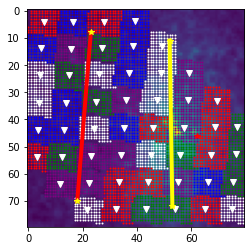

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/02-28-23\selected_zda\analysis03_02_12
slice 3 , rec 12
Processing C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/02-28-23\selected_zda\analysis03_02_12/corners_layer.dat
edge_pts [[18, 70], [53, 72]] axis_pts [[23, 8], [52, 11]]
laminar axis unit vectors: [-0.08038418992031009, 0.996763955011845] [0.01639124023930107, 0.9998656545973652]
ROI centers: [[27.92, 4.25], [27.11, 13.56], [37.2, 23.02], [47.2, 33.02], [57.2, 43.02], [67.2, 53.02], [75.38, 62.94], [38.66, 12.93], [48.66, 22.93], [58.66, 32.93], [68.66, 42.93], [76.43, 52.71], [39.39, 3.84], [49.3, 13.05], [59.3, 23.05], [69.3, 33.05], [76.78, 42.72], [16.41, 4.31], [25.85, 23.42], [35.95, 33.0], [45.95, 43.0], [55.95, 53.0], [65.95, 63.0], [75.08, 72.94], [15.56, 13.94], [5.68, 4.24], [25.06, 33.5], [35.15, 43.05], [45.15, 53.05], [55.15, 63.05], [65.15, 73.05], [14.8, 23.77], [4.8, 13.77], [24.08, 43.37], [34.14, 53.0], [44.14, 63.0], [54.14, 

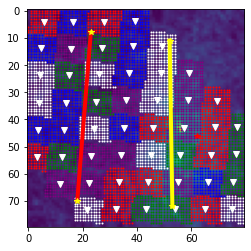

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/02-28-23\selected_zda\analysis06_01_01
slice 6 , rec 1
Processing C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/02-28-23\selected_zda\analysis06_01_01/corners_layer.dat
edge_pts [[4, 65], [41, 72]] axis_pts [[59, 12], [75, 35]]
laminar axis unit vectors: [-0.7200778916462509, 0.6938932410409328] [-0.6766252893427926, 0.736327520755392]
ROI centers: [[64.85, 12.63], [55.01, 4.06], [57.74, 19.36], [68.26, 28.91], [76.45, 38.63], [72.24, 5.8], [75.06, 21.62], [47.51, 9.77], [38.17, 2.58], [50.58, 26.16], [60.87, 35.95], [70.87, 45.95], [77.59, 54.98], [40.15, 16.58], [30.15, 6.76], [20.83, 1.48], [43.38, 33.25], [53.72, 42.9], [63.72, 52.9], [73.61, 62.88], [32.93, 23.43], [22.93, 13.43], [13.07, 4.38], [36.4, 40.27], [46.63, 49.98], [56.63, 59.98], [66.63, 69.98], [75.38, 76.56], [25.91, 30.47], [15.91, 20.47], [5.91, 10.47], [29.12, 47.02], [39.37, 56.71], [49.37, 66.71], [59.12, 75.23], [18.7, 37.4], [8

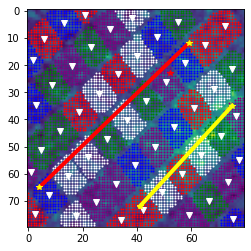

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/02-28-23\selected_zda\analysis06_01_03
slice 6 , rec 3
Processing C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/02-28-23\selected_zda\analysis06_01_03/corners_layer.dat
edge_pts [[4, 65], [41, 72]] axis_pts [[59, 12], [75, 35]]
laminar axis unit vectors: [-0.7200778916462509, 0.6938932410409328] [-0.6766252893427926, 0.736327520755392]
ROI centers: [[64.85, 12.63], [55.01, 4.06], [57.74, 19.36], [68.26, 28.91], [76.45, 38.63], [72.24, 5.8], [75.06, 21.62], [47.51, 9.77], [38.17, 2.58], [50.58, 26.16], [60.87, 35.95], [70.87, 45.95], [77.59, 54.98], [40.15, 16.58], [30.15, 6.76], [20.83, 1.48], [43.38, 33.25], [53.72, 42.9], [63.72, 52.9], [73.61, 62.88], [32.93, 23.43], [22.93, 13.43], [13.07, 4.38], [36.4, 40.27], [46.63, 49.98], [56.63, 59.98], [66.63, 69.98], [75.38, 76.56], [25.91, 30.47], [15.91, 20.47], [5.91, 10.47], [29.12, 47.02], [39.37, 56.71], [49.37, 66.71], [59.12, 75.23], [18.7, 37.4], [8

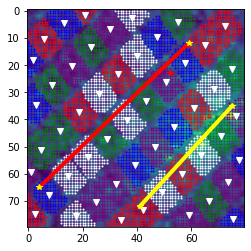

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/02-28-23\selected_zda\analysis06_01_06
slice 6 , rec 6
Processing C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/02-28-23\selected_zda\analysis06_01_06/corners_layer.dat
edge_pts [[4, 65], [41, 72]] axis_pts [[59, 12], [75, 35]]
laminar axis unit vectors: [-0.7200778916462509, 0.6938932410409328] [-0.6766252893427926, 0.736327520755392]
ROI centers: [[64.85, 12.63], [55.01, 4.06], [57.74, 19.36], [68.26, 28.91], [76.45, 38.63], [72.24, 5.8], [75.06, 21.62], [47.51, 9.77], [38.17, 2.58], [50.58, 26.16], [60.87, 35.95], [70.87, 45.95], [77.59, 54.98], [40.15, 16.58], [30.15, 6.76], [20.83, 1.48], [43.38, 33.25], [53.72, 42.9], [63.72, 52.9], [73.61, 62.88], [32.93, 23.43], [22.93, 13.43], [13.07, 4.38], [36.4, 40.27], [46.63, 49.98], [56.63, 59.98], [66.63, 69.98], [75.38, 76.56], [25.91, 30.47], [15.91, 20.47], [5.91, 10.47], [29.12, 47.02], [39.37, 56.71], [49.37, 66.71], [59.12, 75.23], [18.7, 37.4], [8

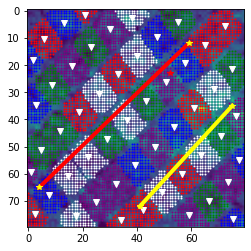

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-07-23\selected_zda
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-07-23\selected_zda\analysis01_01_07
slice 1 , rec 7
Processing C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-07-23\selected_zda\analysis01_01_07/corners_layer.dat
edge_pts [[5, 45], [32, 70]] axis_pts [[62, 13], [74, 37]]
laminar axis unit vectors: [-0.8719837853854813, 0.4895347567076386] [-0.7863183388224226, 0.6178215519319035]
ROI centers: [[68.03, 14.99], [58.01, 5.41], [59.43, 19.34], [70.02, 29.04], [77.14, 38.95], [75.8, 9.57], [67.59, 2.65], [76.84, 24.13], [48.96, 9.64], [39.54, 2.54], [50.71, 24.32], [61.07, 34.16], [71.07, 44.16], [77.62, 53.77], [40.26, 14.56], [30.23, 5.02], [42.16, 29.43], [52.46, 39.16], [62.46, 49.16], [72.46, 59.16], [31.67, 19.69], [21.67, 9.69], [12.4, 2.49], [33.49, 34.29], [43.86, 44.06], [53.86, 54.06], [63.86, 64.06], [73.77, 73.58], [22.88, 24.58], [12.88, 14.58], [3.79,

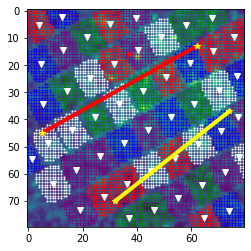

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-07-23\selected_zda\analysis01_02_05
slice 1 , rec 5
Processing C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-07-23\selected_zda\analysis01_02_05/corners_layer.dat
edge_pts [[6, 41], [30, 71]] axis_pts [[60, 11], [74, 36]]
laminar axis unit vectors: [-0.8741572761215377, 0.48564293117863205] [-0.7826010541756486, 0.6225235658215387]
ROI centers: [[66.06, 12.73], [56.18, 3.92], [57.59, 17.4], [68.28, 27.04], [76.25, 36.89], [74.57, 7.73], [65.8, 1.84], [75.97, 21.85], [47.2, 7.58], [38.27, 1.44], [49.0, 22.31], [59.22, 32.14], [69.22, 42.14], [76.89, 51.77], [38.43, 12.57], [28.65, 3.88], [40.29, 27.24], [50.69, 36.96], [60.69, 46.96], [70.69, 56.96], [77.53, 66.6], [29.71, 17.45], [19.71, 7.45], [10.58, 1.44], [31.52, 31.97], [41.84, 41.71], [51.84, 51.71], [61.84, 61.71], [71.84, 71.71], [20.98, 22.39], [10.98, 12.39], [3.06, 4.03], [22.75, 36.81], [33.2, 46.58], [43.2, 56.58], [53.2, 66.58], [62.

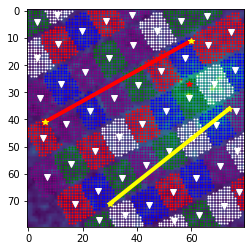

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-07-23\selected_zda\analysis01_03_03
slice 1 , rec 3
Processing C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-07-23\selected_zda\analysis01_03_03/corners_layer.dat
edge_pts [[6, 35], [26, 70]] axis_pts [[57, 10], [76, 36]]
laminar axis unit vectors: [-0.8979207227269799, 0.44015721702302935] [-0.8269265020695281, 0.5623100214072791]
ROI centers: [[63.72, 11.58], [54.07, 3.24], [55.07, 15.9], [65.69, 25.54], [74.81, 35.31], [72.92, 7.07], [64.33, 1.18], [74.35, 20.82], [44.5, 6.21], [45.93, 20.32], [56.37, 30.13], [66.37, 40.13], [75.22, 49.78], [35.39, 10.55], [26.09, 2.8], [36.95, 24.74], [47.32, 34.59], [57.32, 44.59], [67.32, 54.59], [75.87, 64.13], [26.45, 15.01], [16.45, 5.21], [28.01, 29.22], [38.38, 39.05], [48.38, 49.05], [58.38, 59.05], [68.38, 69.05], [75.89, 76.47], [17.51, 19.51], [7.51, 9.51], [18.92, 33.4], [29.35, 43.25], [39.35, 53.25], [49.35, 63.25], [59.35, 73.25], [8.5, 23.69], 

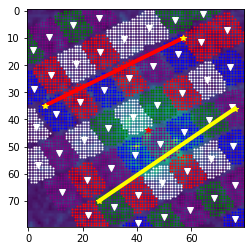

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-07-23\selected_zda\analysis01_03_04
slice 1 , rec 4
Processing C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-07-23\selected_zda\analysis01_03_04/corners_layer.dat
edge_pts [[6, 35], [26, 70]] axis_pts [[57, 10], [76, 36]]
laminar axis unit vectors: [-0.8979207227269799, 0.44015721702302935] [-0.8269265020695281, 0.5623100214072791]
ROI centers: [[63.72, 11.58], [54.07, 3.24], [55.07, 15.9], [65.69, 25.54], [74.81, 35.31], [72.92, 7.07], [64.33, 1.18], [74.35, 20.82], [44.5, 6.21], [45.93, 20.32], [56.37, 30.13], [66.37, 40.13], [75.22, 49.78], [35.39, 10.55], [26.09, 2.8], [36.95, 24.74], [47.32, 34.59], [57.32, 44.59], [67.32, 54.59], [75.87, 64.13], [26.45, 15.01], [16.45, 5.21], [28.01, 29.22], [38.38, 39.05], [48.38, 49.05], [58.38, 59.05], [68.38, 69.05], [75.89, 76.47], [17.51, 19.51], [7.51, 9.51], [18.92, 33.4], [29.35, 43.25], [39.35, 53.25], [49.35, 63.25], [59.35, 73.25], [8.5, 23.69], 

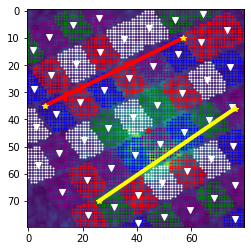

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-07-23\selected_zda\analysis01_04_02
slice 1 , rec 2
Processing C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-07-23\selected_zda\analysis01_04_02/corners_layer.dat
edge_pts [[7, 38], [32, 70]] axis_pts [[49, 11], [73, 35]]
laminar axis unit vectors: [-0.8411784753765535, 0.5407575913134988] [-0.7605645022019074, 0.6492623799284576]
ROI centers: [[55.95, 11.89], [46.31, 3.21], [47.77, 17.07], [58.55, 26.68], [68.55, 36.68], [76.06, 46.31], [64.66, 6.08], [67.23, 20.98], [75.62, 30.61], [73.51, 2.55], [74.6, 15.43], [37.17, 7.31], [28.45, 1.15], [39.39, 22.51], [49.8, 32.21], [59.8, 42.21], [69.8, 52.21], [76.81, 61.48], [28.87, 12.81], [19.06, 3.73], [30.83, 27.87], [41.25, 37.64], [51.25, 47.64], [61.25, 57.64], [71.25, 67.64], [77.0, 76.12], [20.49, 18.21], [10.49, 8.21], [2.97, 1.59], [22.41, 33.21], [32.75, 43.06], [42.75, 53.06], [52.75, 63.06], [62.75, 73.06], [11.94, 23.51], [3.4, 13.86], [14

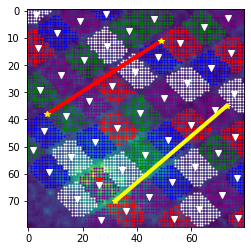

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-07-23\selected_zda\analysis01_05_05
slice 1 , rec 5
Processing C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-07-23\selected_zda\analysis01_05_05/corners_layer.dat
edge_pts [[6, 39], [34, 67]] axis_pts [[48, 11], [75, 38]]
laminar axis unit vectors: [-0.8320502943378437, 0.5547001962252291] [-0.8164156395068652, 0.5774647206268071]
ROI centers: [[54.86, 11.84], [45.25, 3.19], [46.72, 17.09], [57.46, 26.71], [67.46, 36.71], [75.59, 46.43], [63.38, 5.98], [66.05, 20.93], [74.99, 30.67], [72.63, 2.54], [73.83, 15.24], [36.32, 7.38], [27.32, 1.15], [38.47, 22.55], [48.88, 32.36], [58.88, 42.36], [68.88, 52.36], [76.42, 61.71], [27.95, 13.03], [18.1, 3.86], [30.24, 28.28], [40.63, 38.02], [50.63, 48.02], [60.63, 58.02], [70.63, 68.02], [76.89, 76.14], [19.72, 18.44], [9.72, 8.44], [2.8, 1.57], [21.91, 33.7], [32.2, 43.45], [42.2, 53.45], [52.2, 63.45], [62.2, 73.45], [11.55, 24.12], [3.26, 14.48], [13.4

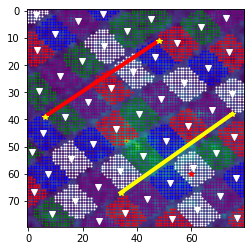

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-07-23\selected_zda\analysis02_01_02
slice 2 , rec 2
Processing C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-07-23\selected_zda\analysis02_01_02/corners_layer.dat
edge_pts [[78, 26], [75, 60]] axis_pts [[13, 8], [9, 47]]
laminar axis unit vectors: [0.9637300218770024, 0.26687908298132373] [0.9811482730462595, 0.19325647802426324]
ROI centers: [[8.21, 11.34], [1.31, 3.69], [17.5, 13.77], [26.9, 23.63], [36.9, 33.63], [46.9, 43.63], [56.9, 53.63], [66.9, 63.63], [75.67, 73.34], [1.55, 11.03], [17.07, 23.19], [27.07, 33.19], [37.07, 43.19], [47.07, 53.19], [57.07, 63.19], [67.07, 73.19], [7.32, 20.93], [17.41, 30.84], [27.41, 40.84], [37.41, 50.84], [47.41, 60.84], [57.41, 70.84], [8.48, 2.17], [27.18, 13.9], [36.84, 23.79], [46.84, 33.79], [56.84, 43.79], [66.84, 53.79], [75.87, 63.47], [17.67, 4.01], [37.11, 16.58], [46.68, 26.49], [56.68, 36.49], [66.68, 46.49], [75.56, 56.2], [27.65, 6.69], [46.6

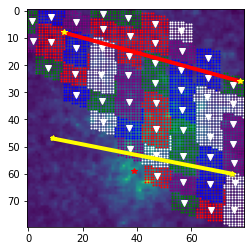

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-07-23\selected_zda\analysis02_01_04
slice 2 , rec 4
Processing C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-07-23\selected_zda\analysis02_01_04/corners_layer.dat
edge_pts [[78, 26], [75, 60]] axis_pts [[13, 8], [9, 47]]
laminar axis unit vectors: [0.9637300218770024, 0.26687908298132373] [0.9811482730462595, 0.19325647802426324]
ROI centers: [[8.21, 11.34], [1.31, 3.69], [17.5, 13.77], [26.9, 23.63], [36.9, 33.63], [46.9, 43.63], [56.9, 53.63], [66.9, 63.63], [75.67, 73.34], [1.55, 11.03], [17.07, 23.19], [27.07, 33.19], [37.07, 43.19], [47.07, 53.19], [57.07, 63.19], [67.07, 73.19], [7.32, 20.93], [17.41, 30.84], [27.41, 40.84], [37.41, 50.84], [47.41, 60.84], [57.41, 70.84], [8.48, 2.17], [27.18, 13.9], [36.84, 23.79], [46.84, 33.79], [56.84, 43.79], [66.84, 53.79], [75.87, 63.47], [17.67, 4.01], [37.11, 16.58], [46.68, 26.49], [56.68, 36.49], [66.68, 46.49], [75.56, 56.2], [27.65, 6.69], [46.6

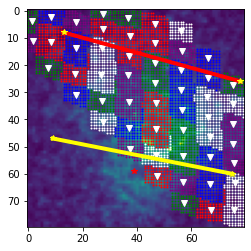

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-07-23\selected_zda\analysis02_02_02
slice 2 , rec 2
Processing C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-07-23\selected_zda\analysis02_02_02/corners_layer.dat
edge_pts [[12, 14], [5, 48]] axis_pts [[73, 26], [70, 60]]
laminar axis unit vectors: [-0.981194456491118, -0.19302186029333468] [-0.9833821803872266, -0.18154747945610336]
ROI centers: [[75.74, 31.36], [67.02, 21.4], [57.02, 11.4], [46.98, 3.53], [67.62, 31.55], [76.23, 41.73], [75.86, 21.02], [66.88, 11.3], [56.83, 2.57], [75.69, 12.95], [66.79, 3.34], [56.87, 21.71], [46.87, 11.71], [36.97, 2.59], [57.82, 29.75], [68.32, 39.83], [76.55, 49.6], [47.31, 19.61], [37.31, 9.61], [27.55, 1.58], [47.95, 27.88], [58.44, 37.94], [68.44, 47.94], [76.45, 57.57], [37.46, 17.74], [27.46, 7.74], [38.0, 25.94], [48.5, 36.0], [58.5, 46.0], [68.5, 56.0], [76.5, 65.67], [27.5, 15.8], [17.5, 5.8], [28.06, 24.0], [38.56, 34.05], [48.56, 44.05], [58.56, 5

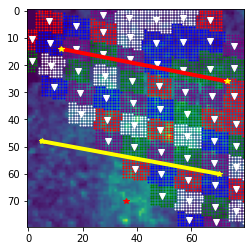

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-07-23\selected_zda\analysis02_03_05
slice 2 , rec 5
Processing C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-07-23\selected_zda\analysis02_03_05/corners_layer.dat
edge_pts [[8, 17], [7, 52]] axis_pts [[74, 30], [70, 59]]
laminar axis unit vectors: [-0.9811482730462595, -0.19325647802426324] [-0.9938837346736189, -0.11043152607484655]
ROI centers: [[76.16, 35.15], [67.85, 25.16], [57.85, 15.16], [47.93, 5.37], [68.38, 35.32], [76.52, 45.33], [76.29, 24.96], [67.82, 15.31], [57.82, 5.31], [76.2, 16.87], [67.68, 7.06], [57.65, 25.47], [47.65, 15.47], [37.65, 5.47], [58.24, 33.84], [68.74, 43.91], [76.67, 53.56], [47.74, 23.71], [37.74, 13.71], [27.79, 3.77], [48.44, 31.89], [58.94, 41.95], [68.94, 51.95], [76.73, 61.68], [37.89, 21.74], [27.89, 11.74], [17.98, 2.6], [38.57, 29.94], [49.12, 40.01], [59.12, 50.01], [69.12, 60.01], [76.84, 69.77], [28.07, 19.86], [18.07, 9.86], [8.0, 1.66], [28.82, 27.8

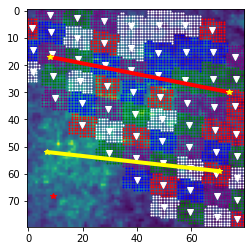

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-07-23\selected_zda\analysis02_03_08
slice 2 , rec 8
Processing C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-07-23\selected_zda\analysis02_03_08/corners_layer.dat
edge_pts [[8, 17], [7, 52]] axis_pts [[74, 30], [70, 59]]
laminar axis unit vectors: [-0.9811482730462595, -0.19325647802426324] [-0.9938837346736189, -0.11043152607484655]
ROI centers: [[76.16, 35.15], [67.85, 25.16], [57.85, 15.16], [47.93, 5.37], [68.38, 35.32], [76.52, 45.33], [76.29, 24.96], [67.82, 15.31], [57.82, 5.31], [76.2, 16.87], [67.68, 7.06], [57.65, 25.47], [47.65, 15.47], [37.65, 5.47], [58.24, 33.84], [68.74, 43.91], [76.67, 53.56], [47.74, 23.71], [37.74, 13.71], [27.79, 3.77], [48.44, 31.89], [58.94, 41.95], [68.94, 51.95], [76.73, 61.68], [37.89, 21.74], [27.89, 11.74], [17.98, 2.6], [38.57, 29.94], [49.12, 40.01], [59.12, 50.01], [69.12, 60.01], [76.84, 69.77], [28.07, 19.86], [18.07, 9.86], [8.0, 1.66], [28.82, 27.8

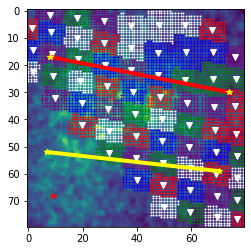

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-07-23\selected_zda\mm_hidden
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-15-23\selected_zda
slice 2 , rec 2
slice 2 , rec 3
slice 2 , rec 4
slice 3 , rec 1
slice 3 , rec 2
slice 3 , rec 4
slice 3 , rec 6
slice 3 , rec 7
slice 3 , rec 9
slice 3 , rec 1
slice 3 , rec 2
slice 3 , rec 3
slice 3 , rec 1
slice 3 , rec 2
slice 3 , rec 3
slice 3 , rec 1
slice 3 , rec 3
slice 3 , rec 4
slice 3 , rec 5
slice 3 , rec 7
slice 3 , rec 8
slice 3 , rec 9
slice 4 , rec 1
slice 4 , rec 2
slice 4 , rec 3
slice 4 , rec 4
slice 4 , rec 5
slice 4 , rec 6
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-15-23\selected_zda\analysis02_01_01
slice 2 , rec 1
Processing C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-15-23\selected_zda\analysis02_01_01/corners_layer.dat
edge_pts [[75, 57], [52, 72]] axis_pts [[16, 9], [8, 34]]
laminar axis unit vectors: [0.7757116786991037, 0.6310874

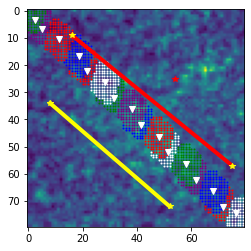

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-15-23\selected_zda\analysis02_01_04
slice 2 , rec 4
Processing C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-15-23\selected_zda\analysis02_01_04/corners_layer.dat
edge_pts [[75, 57], [52, 72]] axis_pts [[16, 9], [8, 34]]
laminar axis unit vectors: [0.7757116786991037, 0.63108746741622] [0.7568230077691596, 0.6536198703460924]
ROI centers: [[11.13, 10.45], [2.46, 3.5], [18.64, 16.69], [28.11, 26.28], [38.11, 36.28], [48.11, 46.28], [58.11, 56.28], [68.11, 66.28], [76.46, 74.51], [5.17, 6.71], [21.53, 22.16], [31.53, 32.16], [41.53, 42.16], [51.53, 52.16], [61.53, 62.16], [71.53, 72.16]]
Created file: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-15-23\selected_zda\analysis02_01_04/sq_rois.dat
File created:  C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-15-23\selected_zda\analysis02_01_04/corners_layer_laminar_distances.txt


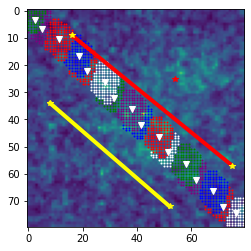

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-15-23\selected_zda\analysis02_01_06
slice 2 , rec 6
Processing C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-15-23\selected_zda\analysis02_01_06/corners_layer.dat
edge_pts [[75, 57], [52, 72]] axis_pts [[16, 9], [8, 34]]
laminar axis unit vectors: [0.7757116786991037, 0.63108746741622] [0.7568230077691596, 0.6536198703460924]
ROI centers: [[11.13, 10.45], [2.46, 3.5], [18.64, 16.69], [28.11, 26.28], [38.11, 36.28], [48.11, 46.28], [58.11, 56.28], [68.11, 66.28], [76.46, 74.51], [5.17, 6.71], [21.53, 22.16], [31.53, 32.16], [41.53, 42.16], [51.53, 52.16], [61.53, 62.16], [71.53, 72.16]]
Created file: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-15-23\selected_zda\analysis02_01_06/sq_rois.dat
File created:  C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-15-23\selected_zda\analysis02_01_06/corners_layer_laminar_distances.txt


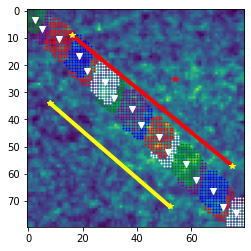

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-15-23\selected_zda\analysis02_02_03
slice 2 , rec 3
Processing C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-15-23\selected_zda\analysis02_02_03/corners_layer.dat
edge_pts [[75, 60], [48, 72]] axis_pts [[18, 8], [8, 31]]
laminar axis unit vectors: [0.738766024783967, 0.6739619875222155] [0.6983238520753277, 0.7157819483772108]
ROI centers: [[12.87, 9.18], [3.27, 2.9], [20.1, 15.76], [29.55, 25.36], [39.55, 35.36], [49.55, 45.36], [59.55, 55.36], [69.55, 65.36], [77.07, 74.37], [7.05, 5.1], [24.12, 20.47], [34.12, 30.47], [44.12, 40.47], [54.12, 50.47], [64.12, 60.47], [74.12, 70.47]]
Created file: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-15-23\selected_zda\analysis02_02_03/sq_rois.dat
File created:  C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-15-23\selected_zda\analysis02_02_03/corners_layer_laminar_distances.txt


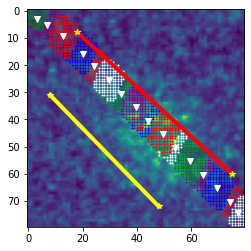

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-15-23\selected_zda\analysis02_03_02
slice 2 , rec 2
Processing C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-15-23\selected_zda\analysis02_03_02/corners_layer.dat
edge_pts [[73, 59], [42, 71]] axis_pts [[19, 8], [9, 33]]
laminar axis unit vectors: [0.7270131525498175, 0.6866235329637166] [0.655686655446243, 0.7550331183926435]
ROI centers: [[14.06, 9.2], [4.16, 2.75], [21.15, 15.79], [30.53, 25.33], [40.53, 35.33], [50.53, 45.33], [60.53, 55.33], [70.53, 65.33], [77.52, 74.62], [8.53, 4.94], [25.28, 20.28], [35.28, 30.28], [45.28, 40.28], [55.28, 50.28], [65.28, 60.28], [75.28, 70.28]]
Created file: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-15-23\selected_zda\analysis02_03_02/sq_rois.dat
File created:  C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-15-23\selected_zda\analysis02_03_02/corners_layer_laminar_distances.txt


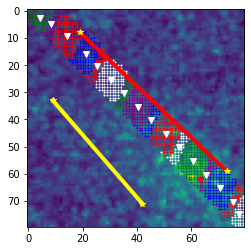

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-15-23\selected_zda\analysis02_04_02
slice 2 , rec 2
Processing C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-15-23\selected_zda\analysis02_04_02/corners_layer.dat
edge_pts [[75, 67], [52, 73]] axis_pts [[14, 7], [7, 33]]
laminar axis unit vectors: [0.7129262923855025, 0.7012389761168877] [0.7474093186836598, 0.6643638388299198]
ROI centers: [[9.57, 8.06], [1.42, 2.65], [16.55, 14.98], [26.0, 24.5], [36.0, 34.5], [46.0, 44.5], [56.0, 54.5], [66.0, 64.5], [75.43, 73.65], [3.97, 4.7], [20.85, 19.56], [30.85, 29.56], [40.85, 39.56], [50.85, 49.56], [60.85, 59.56], [70.85, 69.56]]
Created file: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-15-23\selected_zda\analysis02_04_02/sq_rois.dat
File created:  C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-15-23\selected_zda\analysis02_04_02/corners_layer_laminar_distances.txt


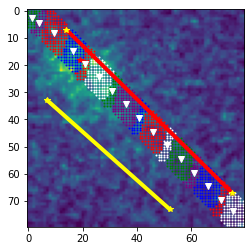

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-15-23\selected_zda\analysis02_06_01
slice 2 , rec 1
Processing C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-15-23\selected_zda\analysis02_06_01/corners_layer.dat
edge_pts [[75, 60], [49, 72]] axis_pts [[25, 8], [7, 29]]
laminar axis unit vectors: [0.6931087162517846, 0.720833064901856] [0.6987395238751688, 0.7153761792055299]
ROI centers: [[18.92, 8.16], [8.19, 1.85], [25.75, 15.25], [35.29, 24.75], [45.29, 34.75], [55.29, 44.75], [65.29, 54.75], [74.61, 64.84], [13.33, 3.82], [30.35, 19.4], [40.35, 29.4], [50.35, 39.4], [60.35, 49.4], [70.35, 59.4]]
Created file: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-15-23\selected_zda\analysis02_06_01/sq_rois.dat
File created:  C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-15-23\selected_zda\analysis02_06_01/corners_layer_laminar_distances.txt


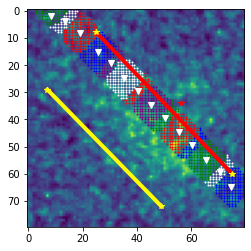

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-15-23\selected_zda\analysis02_06_05
slice 2 , rec 5
Processing C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-15-23\selected_zda\analysis02_06_05/corners_layer.dat
edge_pts [[75, 60], [49, 72]] axis_pts [[25, 8], [7, 29]]
laminar axis unit vectors: [0.6931087162517846, 0.720833064901856] [0.6987395238751688, 0.7153761792055299]
ROI centers: [[18.92, 8.16], [8.19, 1.85], [25.75, 15.25], [35.29, 24.75], [45.29, 34.75], [55.29, 44.75], [65.29, 54.75], [74.61, 64.84], [13.33, 3.82], [30.35, 19.4], [40.35, 29.4], [50.35, 39.4], [60.35, 49.4], [70.35, 59.4]]
Created file: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-15-23\selected_zda\analysis02_06_05/sq_rois.dat
File created:  C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-15-23\selected_zda\analysis02_06_05/corners_layer_laminar_distances.txt


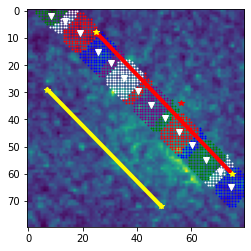

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-15-23\selected_zda\analysis02_06_06
slice 2 , rec 6
Processing C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-15-23\selected_zda\analysis02_06_06/corners_layer.dat
edge_pts [[75, 60], [49, 72]] axis_pts [[25, 8], [7, 29]]
laminar axis unit vectors: [0.6931087162517846, 0.720833064901856] [0.6987395238751688, 0.7153761792055299]
ROI centers: [[18.92, 8.16], [8.19, 1.85], [25.75, 15.25], [35.29, 24.75], [45.29, 34.75], [55.29, 44.75], [65.29, 54.75], [74.61, 64.84], [13.33, 3.82], [30.35, 19.4], [40.35, 29.4], [50.35, 39.4], [60.35, 49.4], [70.35, 59.4]]
Created file: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-15-23\selected_zda\analysis02_06_06/sq_rois.dat
File created:  C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-15-23\selected_zda\analysis02_06_06/corners_layer_laminar_distances.txt


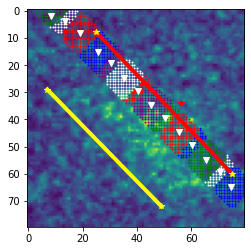

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-15-23\selected_zda\analysis03_01_03
slice 3 , rec 3
Processing C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-15-23\selected_zda\analysis03_01_03/corners_layer.dat
edge_pts [[76, 32], [73, 61]] axis_pts [[8, 31], [8, 60]]
laminar axis unit vectors: [0.9998918860475786, 0.014704292441876156] [0.999881677808259, 0.015382795043203983]
ROI centers: [[4.0, 35.5], [13.0, 35.5], [22.5, 45.5], [32.5, 55.5], [42.5, 65.5], [52.5, 74.5], [12.5, 46.5], [22.5, 56.5], [32.5, 66.5], [42.5, 75.5], [4.0, 24.5], [23.0, 34.5], [32.5, 44.5], [42.5, 54.5], [52.5, 64.5], [62.5, 74.5], [13.5, 24.5], [4.0, 14.5], [33.0, 34.5], [42.5, 44.5], [52.5, 54.5], [62.5, 64.5], [72.5, 74.5], [23.5, 24.5], [13.5, 14.5], [4.0, 4.5], [42.88, 34.71], [52.38, 44.69], [62.38, 54.69], [72.38, 64.69], [33.37, 24.74], [23.37, 14.74], [13.37, 4.74], [53.12, 35.24], [62.63, 45.21], [72.63, 55.21], [43.63, 25.26], [33.63, 15.26], [23.63, 5.26]

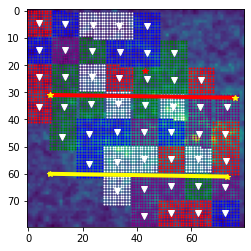

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-15-23\selected_zda\analysis03_01_05
slice 3 , rec 5
Processing C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-15-23\selected_zda\analysis03_01_05/corners_layer.dat
edge_pts [[76, 32], [73, 61]] axis_pts [[8, 31], [8, 60]]
laminar axis unit vectors: [0.9998918860475786, 0.014704292441876156] [0.999881677808259, 0.015382795043203983]
ROI centers: [[4.0, 35.5], [13.0, 35.5], [22.5, 45.5], [32.5, 55.5], [42.5, 65.5], [52.5, 74.5], [12.5, 46.5], [22.5, 56.5], [32.5, 66.5], [42.5, 75.5], [4.0, 24.5], [23.0, 34.5], [32.5, 44.5], [42.5, 54.5], [52.5, 64.5], [62.5, 74.5], [13.5, 24.5], [4.0, 14.5], [33.0, 34.5], [42.5, 44.5], [52.5, 54.5], [62.5, 64.5], [72.5, 74.5], [23.5, 24.5], [13.5, 14.5], [4.0, 4.5], [42.88, 34.71], [52.38, 44.69], [62.38, 54.69], [72.38, 64.69], [33.37, 24.74], [23.37, 14.74], [13.37, 4.74], [53.12, 35.24], [62.63, 45.21], [72.63, 55.21], [43.63, 25.26], [33.63, 15.26], [23.63, 5.26]

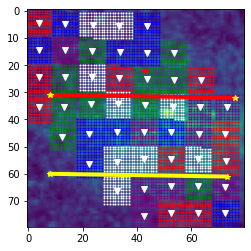

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-15-23\selected_zda\analysis03_01_08
slice 3 , rec 8
Processing C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-15-23\selected_zda\analysis03_01_08/corners_layer.dat
edge_pts [[76, 32], [73, 61]] axis_pts [[8, 31], [8, 60]]
laminar axis unit vectors: [0.9998918860475786, 0.014704292441876156] [0.999881677808259, 0.015382795043203983]
ROI centers: [[4.0, 35.5], [13.0, 35.5], [22.5, 45.5], [32.5, 55.5], [42.5, 65.5], [52.5, 74.5], [12.5, 46.5], [22.5, 56.5], [32.5, 66.5], [42.5, 75.5], [4.0, 24.5], [23.0, 34.5], [32.5, 44.5], [42.5, 54.5], [52.5, 64.5], [62.5, 74.5], [13.5, 24.5], [4.0, 14.5], [33.0, 34.5], [42.5, 44.5], [52.5, 54.5], [62.5, 64.5], [72.5, 74.5], [23.5, 24.5], [13.5, 14.5], [4.0, 4.5], [42.88, 34.71], [52.38, 44.69], [62.38, 54.69], [72.38, 64.69], [33.37, 24.74], [23.37, 14.74], [13.37, 4.74], [53.12, 35.24], [62.63, 45.21], [72.63, 55.21], [43.63, 25.26], [33.63, 15.26], [23.63, 5.26]

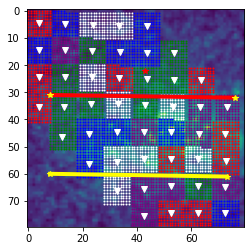

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-15-23\selected_zda\analysis03_04_02
slice 3 , rec 2
Processing C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-15-23\selected_zda\analysis03_04_02/corners_layer.dat
edge_pts [[75, 44], [75, 68]] axis_pts [[8, 36], [7, 63]]
laminar axis unit vectors: [0.9929467931694284, 0.11856081112470786] [0.9973076252903365, 0.07333144303605414]
ROI centers: [[3.99, 40.05], [12.99, 41.05], [22.5, 51.0], [32.5, 61.0], [42.5, 71.0], [52.24, 77.17], [12.51, 51.55], [22.51, 61.55], [32.51, 71.55], [4.0, 29.5], [23.01, 40.56], [32.5, 50.5], [42.5, 60.5], [52.5, 70.5], [62.15, 77.76], [13.52, 30.6], [4.04, 20.67], [33.02, 41.73], [42.52, 51.65], [52.52, 61.65], [62.52, 71.65], [23.62, 31.86], [13.62, 21.86], [4.09, 11.9], [43.04, 42.95], [52.57, 52.91], [62.57, 62.91], [72.57, 72.91], [33.5, 33.0], [23.41, 23.09], [13.41, 13.09], [4.0, 3.5], [52.86, 44.05], [62.36, 54.05], [72.36, 64.05], [43.37, 34.15], [33.37, 24.15]

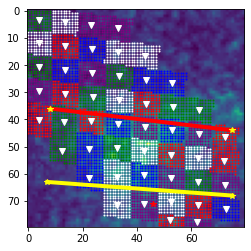

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-15-23\selected_zda\analysis03_04_06
slice 3 , rec 6
Processing C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-15-23\selected_zda\analysis03_04_06/corners_layer.dat
edge_pts [[75, 44], [75, 68]] axis_pts [[8, 36], [7, 63]]
laminar axis unit vectors: [0.9929467931694284, 0.11856081112470786] [0.9973076252903365, 0.07333144303605414]
ROI centers: [[3.99, 40.05], [12.99, 41.05], [22.5, 51.0], [32.5, 61.0], [42.5, 71.0], [52.24, 77.17], [12.51, 51.55], [22.51, 61.55], [32.51, 71.55], [4.0, 29.5], [23.01, 40.56], [32.5, 50.5], [42.5, 60.5], [52.5, 70.5], [62.15, 77.76], [13.52, 30.6], [4.04, 20.67], [33.02, 41.73], [42.52, 51.65], [52.52, 61.65], [62.52, 71.65], [23.62, 31.86], [13.62, 21.86], [4.09, 11.9], [43.04, 42.95], [52.57, 52.91], [62.57, 62.91], [72.57, 72.91], [33.5, 33.0], [23.41, 23.09], [13.41, 13.09], [4.0, 3.5], [52.86, 44.05], [62.36, 54.05], [72.36, 64.05], [43.37, 34.15], [33.37, 24.15]

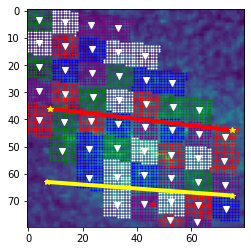

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/mm_hidden/03-15-23\selected_zda\mm_hidden




	tolerance exception count: 0
	slice directory count: 80
	Number of measurements made: 68


In [4]:
for subdir, dirs, files in os.walk(data_dir):
    if 'notUsable' in subdir:
        continue
    if 'selected_zda' not in subdir:
        continue
    print(subdir)
    subdir += '/'
    if len(files) > 0:
        slice_count += 1
    for filename in files:
        fn = filename.split(".")[0]
        if fn.endswith("_snr") or fn.startswith("SNR"):
            name_parse = filename[:8]  # of the format 07-01-01
            if fn.startswith("SNR"):
                name_parse = filename[4:11]
            try:
                sep = "_"
                if "-" in name_parse:
                    sep = "-"
                slic, loc, rec = [int(x) for x in name_parse.split(sep)]
            except ValueError:
                print("Could not parse:", name_parse)
                continue
            if slic not in image_data:
                image_data[slic] = {}
            if loc not in image_data[slic]:
                image_data[slic][loc] = {}
            snr = np.loadtxt(subdir + filename,
                             delimiter='\t',
                             usecols=(1,))
            width = int(np.sqrt(snr.shape[0]))
            snr = snr.reshape((width, width))
            n_grid_size = int(width / n_sq)  # how many squares will fit along frame edge

            print("slice", slic, ", rec", rec)

            # open corners, 2 points p1, p2 to define the edge along which to measure
            
            la_file = subdir + corners_file_prefix_layer + '.dat'
            lines = None
            if os.path.exists(la_file):
                print("Processing", la_file)
                meas_count += 1
                with open(la_file, 'r') as f:
                    lines = f.readlines() 
                corners = [int(x) for x in lines[4:]] # the last 4 lines are diode numbers of corners
                layer_axes = LayerAxes(corners)
                laminar_axis, laminar_axis_2 = layer_axes.get_layer_axes()
                print("laminar axis unit vectors:", laminar_axis.get_unit_vector(), 
                      laminar_axis_2.get_unit_vector())

                # make our own square ROIs aligned to the list of edges and write them to a .dat file
                roi_cr = SquareROICreator(layer_axes, roi_width=n_sq)
                rois = roi_cr.get_rois()  # list of LaminarROI objects
                roi_centers = [r.get_center() for r in rois]
                roi_centers = [[round(r[0], 2), round(r[1], 2)] for r in roi_centers]
                #print("ROI centers:", roi_centers)

                # write these ROIs to file
                roi_cr.write_roi_file(subdir, rois_file_prefix)

                
                
                
                
                
                
                
                
                
                
                # open stim point roi as a single integer (its diode number) in variable stim_pt
                sp_file = subdir + electrode_file_prefix + '.dat'
                with open(sp_file, 'r') as f:
                    lines = f.readlines()
                stim_pt = int(lines[-1]) # last line is always electrode location
                aux_obj = LaminarROI([stim_pt]).get_points()
                stim_pt = aux_obj[0]  # should be a list of len 2, representing px location [x, y]
                #print("Stim point:", stim_pt)

                # run laminar dist computation
                laminar_distances_obj = LaminarDistance(laminar_axis, rois, stim_pt)
                laminar_distances = laminar_distances_obj.compute_laminar_distances()
                laminar_distances = [round(ld, 2) for ld in laminar_distances]
                #print('laminar_distances:', laminar_distances)  # a list of integers with same indexing as rois

                # run laminar dist again with the other axis
                laminar_distances_2 = LaminarDistance(laminar_axis_2, rois, stim_pt).compute_laminar_distances()
                laminar_distances_2 = [round(ld, 2) for ld in laminar_distances_2]
                #print('laminar_distances 2:', laminar_distances_2)  # a list of integers with same indexing as rois

                # write averaged laminar distances to file
                avg_laminar_distances = [round(
                    (laminar_distances[i] + laminar_distances_2[i]) / 2,
                    2)
                                        for i in range(len(laminar_distances))]
                #print('laminar_distances averaged :', avg_laminar_distances) 
                ld_filename_base = la_file[:-4] + "_"
                laminar_distances_obj.write_laminar_distance_file(ld_filename_base, avg_laminar_distances)

                image_data[slic][loc][rec] = {
                    'snr': snr,
                    'filename': filename,
                    'laminar_distances': laminar_distances}

                # Now that the data is stored, show intermediate computations in plot
                if n_plots > 0:
                    lines = [laminar_axis.get_line_repr(),
                             laminar_axis_2.get_line_repr()]
                    line_colors = ['red', 'yellow']
                    linewidths = [4,4]
                    other_colors = ['red', 'green', 'blue', 'white', 'purple']
                    roi_colors = []

                    # laminar aux lines
                    uv = laminar_axis.get_unit_vector()
                    for i in range(len(laminar_distances)):
                        ld = laminar_distances[i]
                        jiggle = i - int(len(laminar_distances) / 2)
                        uv_perp = Line(laminar_axis.get_start_point(), 
                                       laminar_axis_2.get_start_point()).get_unit_vector()
                        stim_proxy_pt = [stim_pt[0] - jiggle * uv_perp[0], 
                                         stim_pt[1] - jiggle * uv_perp[1]]
                        measure_vector = [uv[0] * ld + stim_proxy_pt[0], uv[1] * ld + stim_proxy_pt[1]]
                        lines.append([measure_vector, stim_proxy_pt])
                        this_color = other_colors[i % len(other_colors)]
                        line_colors.append(this_color)
                        roi_colors.append(this_color)
                        linewidths.append(1)

                    GridVisualization(snr, 
                                         stim_pt, 
                                         roi_centers, 
                                         layer_axes.get_corners(),
                                         lines,
                                         line_colors,
                                         linewidths,
                                         rois,
                                         roi_colors,
                                         save_dir=subdir+"LaminarVisual"+name_parse+'.png')
                    n_plots -= 1

print("\n\n\n\n\ttolerance exception count:", tol_exception_count)
print("\tslice directory count:", slice_count)
print("\tNumber of measurements made:", meas_count)